In [1]:
import pandas as pd
from math import asin, sin, cos, sqrt, radians
import gme as gme
import numpy as np
import statsmodels.api as sm

In [2]:
# TradeData_11_13_2023_9_33_13.csv data for trade 2022 contry to country UN com trade 

In [3]:
data = pd.read_csv("TradeData_11_13_2023_9_33_13.csv", encoding='latin1')


In [4]:
# What is FOB value?
# (a) FOB Value = Ex-Factory Price + Other Costs. (b) Other Costs in the calculation of the FOB value shall refer to the costs incurred in placing the goods in the ship for export, 
# including but not limited to, domestic transport costs, storage and warehousing, port handling, brokerage fees, service charges, et cetera.

In [5]:
def haversine_distance(lat1, long1, lat2, long2, R=6371.0):
    """
    Calculate the Haversine distance between two points on the Earth's surface.

    Parameters:
    - lat1, long1: Latitude and longitude of the first point in degrees
    - lat2, long2: Latitude and longitude of the second point in degrees
    - R: Radius of the Earth in kilometers (default is 6371.0 km)

    Returns:
    - Distance between the two points in kilometers
    """
    lat1, long1, lat2, long2 = map(float, [lat1, long1, lat2, long2])
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])

    dlat = lat2 - lat1
    dlong = long2 - long1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlong/2)**2
    c = 2 * asin(sqrt(a))

    distance_km = R * c
    return distance_km


In [6]:
## Data cleaning
# 1 Removing all trades Country to All
all_mask = data.PartnerCode != 'ALL'
data = data[all_mask]
# 2 Eliminate Ref period, all 2022, FreqCode, TypeCode (Goods) -> select columns
export_data = data[['RefYear','ReporterCode','ReporterISO','ReporterDesc','PartnerCode','PartnerISO','PartnerDesc','Fobvalue']]
# 3 Eliminate all aggragtes of country (Europe, ecc...) using  ISO 3166
single_countries = pd.read_excel("CODE_ONLY_STATE.xlsx")
mask_single_countries = export_data['ReporterISO'].isin(single_countries['ISO-alpha3 code'])
export_data_singles = export_data[mask_single_countries]
## Adding latitude and longitude data Countries with their (ISO 3166-1) Alpha-2 code, Alpha-3 code, UN M49, average latitude and longitude coordinates
lat_long = pd.read_csv("lat_long.csv")
lat_long = lat_long.replace('"', '', regex=True)
lat_long = lat_long.applymap(lambda x: x.strip() if isinstance(x, str) else x)
lat_long_rep = lat_long.add_suffix('_rep')
lat_long_part = lat_long.add_suffix('_part')
## Now I will merge the data lat_long with the export database first with reporter then partner in order to calculate the distances
merged_data = pd.merge(export_data_singles, lat_long_rep, left_on='ReporterISO', right_on='Alpha-3 code_rep', how = 'left')
merged_data = pd.merge(merged_data, lat_long_part, left_on='PartnerISO', right_on='Alpha-3 code_part', how = 'left')
merged_data = merged_data.dropna()

## Database of gravity data
gravity_data = merged_data[['RefYear','ReporterISO','PartnerISO','Fobvalue','Latitude (average)_rep','Longitude (average)_rep','Latitude (average)_part','Longitude (average)_part']]
gravity_data = gravity_data.copy()
gravity_data.rename(columns={'ReporterISO': 'ReporterISO',
                             'PartnerISO': 'PartnerISO',
                             'Fobvalue': 'value',
                             'Latitude (average)_rep': 'Lat_reporter',
                             'Longitude (average)_rep': 'Long_reporter',
                             'Latitude (average)_part': 'Lat_part',
                             'Longitude (average)_part': 'Long_part',
                            'RefYear': 'year'}, inplace=True)

gravity_data['distance'] = gravity_data.apply(lambda row: haversine_distance(row['Lat_reporter'], row['Long_reporter'], row['Lat_part'], row['Long_part'], R=6371.0), axis=1)
# gravity_data['distance'] = np.log(gravity_data['distance'])
gravity_data_distance = gravity_data[['year','ReporterISO','PartnerISO','value','distance']]

## Eliminating duplicates
# Assuming 'value' is the column you want to consider along with 'distance'
gravity_data_fin = gravity_data.drop_duplicates(subset=['distance', 'value'])
## Keeping just the countries for which there is code in parter and reporter
mask_country = gravity_data_fin['PartnerISO'].isin(gravity_data_fin['ReporterISO'])
gravity_data_final = gravity_data_fin[mask_country]

In [7]:
## GDP data from world bank

In [8]:
gdp = pd.read_csv('API_NY.GDP.MKTP.CD_DS2_en_csv_v2_6011335.csv', skiprows=3)
gdp_2022 = gdp[['Country Code','2022']]
gdp_2022 = gdp_2022.dropna()

In [9]:
gravity_data_final.columns

Index(['year', 'ReporterISO', 'PartnerISO', 'value', 'Lat_reporter',
       'Long_reporter', 'Lat_part', 'Long_part', 'distance'],
      dtype='object')

In [18]:
## Merging
gravity = pd.merge(gravity_data_final,gdp_2022,left_on = 'ReporterISO',right_on='Country Code', how = 'left')
gravity = pd.merge(gravity,gdp_2022,left_on = 'PartnerISO',right_on='Country Code',how = 'left')

GRAVITY = gravity[['year', 'ReporterISO', 'PartnerISO', 'value', 'distance','2022_x', '2022_y']].copy()
GRAVITY.rename(columns={'2022_x': 'GDP_rep',
                             '2022_y': 'GDP_part',
                             }, inplace=True)
GRAVITY = GRAVITY.dropna()

In [19]:
X = sm.add_constant(np.log(GRAVITY[['GDP_rep', 'GDP_part', 'distance']]))
y = np.log(GRAVITY['value'])

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     8914.
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:28:23   Log-Likelihood:                -31950.
No. Observations:               13888   AIC:                         6.391e+04
Df Residuals:                   13884   BIC:                         6.394e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.9595      0.437    -75.383      0.0

       Residuals  Predicted     Actual
0      -4.452028  13.019677   8.567649
1      -1.539317  13.703885  12.164569
2      -1.499089  14.465321  12.966232
3      -0.405574  17.633492  17.227918
4      -1.248862  16.830696  15.581834
...          ...        ...        ...
14320   0.319685  16.575824  16.895509
14321  -0.569506  16.008459  15.438953
14322  -0.055947  17.848507  17.792560
14323  -2.021733  12.293099  10.271366
14324  -1.926534  13.092417  11.165883

[13888 rows x 3 columns]


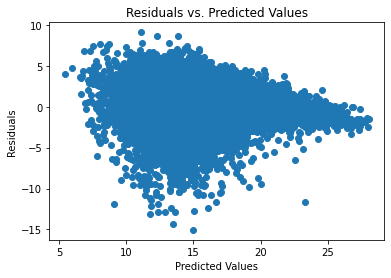

In [21]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Assuming you have already fitted your OLS model and stored the results in the 'results' variable
# If not, fit the model first using the code provided earlier

# Access the residuals
residuals = results.resid

# Create a DataFrame to store the residuals along with other relevant variables
residuals_df = pd.DataFrame({'Residuals': residuals, 'Predicted': results.fittedvalues, 'Actual': y})

# Display the DataFrame
print(residuals_df)


import matplotlib.pyplot as plt

# Scatter plot of predicted vs. residuals
plt.scatter(results.fittedvalues, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()
